# **Predicting Popularity using Ukraine Conflict Tweets**

**GROUP 10 - SAS:**  

* Stephanie Chen (schen176)  
* Anushree Vilas Pimpalkar (avp4)  
* Shantanu Solanki (solanki7) 

### Install PySpark

In [ ]:
%%bash 

## Setup Spark on Colab
pip install -q pyspark
apt-get install -yq openjdk-8-jdk-headless

## Setup port-forwarding

# Download ngrok
wget -q https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
# Unload ngrok
unzip -q ngrok-stable-linux-amd64.zip

Reading package lists...
Building dependency tree...
Reading state information...
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 42 not upgraded.
Need to get 36.5 MB of archives.
After this operation, 143 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 openjdk-8-jre-headless amd64 8u312-b07-0ubuntu1~18.04 [28.2 MB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 openjdk-8-jdk-headless amd64 8u312-b

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [ ]:
import pyspark 
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

# Set configuration scope to be local and use port 4050
config_scope = SparkConf().set("spark.ui.port", "4050")

# Create the connection to a Spark cluster
sc = pyspark.SparkContext(conf = config_scope)

# Adjust context from WARN to INFO level
# Options: ALL, DEBUG, ERROR, FATAL, INFO, OFF, TRACE, WARN
sc.setLogLevel("INFO")

# Create a session to programmatically build Spark RDD, DataFrame and DataSet
spark = SparkSession.builder.getOrCreate()

In [ ]:
%%bash

## Setup port-forwarding

# Download ngrok
wget -q https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
# Unload ngrok
unzip -qo ngrok-stable-linux-amd64.zip

### Install ngrok

In [ ]:
# Set ngrok authtoken once per-session
!./ngrok authtoken 286rzhgBkhBeIztD7IryWlIPzPL_78TuD6FWoQyDqpA2NdBkZ

# Start an HTTP tunnel forwarding to your local port 4050
get_ipython().system_raw('./ngrok http 4050 &')

# Open a local host port
!curl -s http://localhost:4040/api/tunnels

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml
{"tunnels":[],"uri":"/api/tunnels"}


## Environment Setup

### Mount Google Drive

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Data_480

/content/drive/.shortcut-targets-by-id/19avAQ6MusyUGaQiJDqGXLxBKnCbTBOhb/Data_480


In [ ]:
%%bash 
pip install pyspark
pip install -U -q PyDrive
apt install openjdk-8-jdk-headless -qq

openjdk-8-jdk-headless is already the newest version (8u312-b07-0ubuntu1~18.04).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.


### Enable packages

In [ ]:
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%tensorflow_version 2.x
import tensorflow as tf
from pyspark.sql.functions import isnan, when, count, col, countDistinct
import warnings 
warnings.filterwarnings("ignore")
print(f"python: {sys.version}")
print(f"pandas: {np.__version__}")
print(f"tensorflow: {tf.__version__}")
# Detect if a GPU is present
gpus = tf.config.list_physical_devices('GPU')

if gpus:
  print(f"GPU Enabled: True")
else:
  print(f"GPU Enabled: False")

try:
  from google.colab import drive
  is_google_colab = True

  print("Notebook is on Google CoLab")
except:
  is_google_colab = False
  print("Notebook is being run locally or through another source.")


python: 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
pandas: 1.21.6
tensorflow: 2.8.0
GPU Enabled: False
Notebook is on Google CoLab


In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
!tar xf spark-3.0.1-bin-hadoop2.7.tgz

tar: spark-3.0.1-bin-hadoop2.7.tgz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


### Initialize Spark cluster

In [ ]:
spark

## Load Data

### Rename file

In [ ]:
%%bash
#/content/UkraineCombinedTweetsDeduped20220227-131611.csv.gzip
#/content/UkraineCombinedTweetsDeduped20220227-131611.csv.gz
#/content/0401_UkraineCombinedTweetsDeduped.csv.gzip
cp /content/drive/MyDrive/Data_480/0401_UkraineCombinedTweetsDeduped.csv.gzip /content/drive/MyDrive/Data_480/0401_UkraineCombinedTweetsDeduped.csv.gz


#other files are directly renamed

### Extract with gunzip

### Read with Spark

In [ ]:
df = spark.read.csv("/content/drive/MyDrive/Data_480", 
                    sep=',', header='true', inferSchema = 'true')

In [ ]:
df.show(5)

+--------------------+------------------+------------+--------------------+--------+--------------------+-------------------+--------------------+-------------+--------------------+--------------------+------------+----+--------+--------------------+-----------+--------------+-----------+
|                 _c0|            userid|    username|            acctdesc|location|           following|          followers|         totaltweets|usercreatedts|             tweetid|      tweetcreatedts|retweetcount|text|hashtags|            language|coordinates|favorite_count|extractedts|
+--------------------+------------------+------------+--------------------+--------+--------------------+-------------------+--------------------+-------------+--------------------+--------------------+------------+----+--------+--------------------+-----------+--------------+-----------+
|                   0|699759327913967617|RuidoEnLaRed|Periodismo audiov...|    null|                null|               null|     

## Exploratory Data Analysis

### Basic Information

In [ ]:
print(df.count(), len(df.columns)) #no of rows, cols

39047346 18


In [ ]:
df.columns

['_c0',
 'userid',
 'username',
 'acctdesc',
 'location',
 'following',
 'followers',
 'totaltweets',
 'usercreatedts',
 'tweetid',
 'tweetcreatedts',
 'retweetcount',
 'text',
 'hashtags',
 'language',
 'coordinates',
 'favorite_count',
 'extractedts']

In [ ]:
#drop 1st col

df = df.drop("_c0")

#selecting only English tweets and only 100000 rows

df_en = df.filter(df.language == "en").limit(100000)


In [ ]:
df_en.count()

100000

### Check for nulls

In [ ]:
df_en.select([count(when(isnan(c)| col(c).isNull(), c)).alias(c) for c in df_en.columns]).show(5)

+------+--------+--------+--------+---------+---------+-----------+-------------+-------+--------------+------------+----+--------+--------+-----------+--------------+-----------+
|userid|username|acctdesc|location|following|followers|totaltweets|usercreatedts|tweetid|tweetcreatedts|retweetcount|text|hashtags|language|coordinates|favorite_count|extractedts|
+------+--------+--------+--------+---------+---------+-----------+-------------+-------+--------------+------------+----+--------+--------+-----------+--------------+-----------+
|     8|       2|   26257|   42121|        0|        0|          0|            0|      0|             0|           0|   0|       0|       0|      99984|             0|          0|
+------+--------+--------+--------+---------+---------+-----------+-------------+-------+--------------+------------+----+--------+--------+-----------+--------------+-----------+



### Check distinct values

In [ ]:
df_en.agg(*(countDistinct(col(c)).alias(c) for c in df_en.columns)).show()

+------+--------+--------+--------+---------+---------+-----------+-------------+-------+--------------+------------+-----+--------+--------+-----------+--------------+-----------+
|userid|username|acctdesc|location|following|followers|totaltweets|usercreatedts|tweetid|tweetcreatedts|retweetcount| text|hashtags|language|coordinates|favorite_count|extractedts|
+------+--------+--------+--------+---------+---------+-----------+-------------+-------+--------------+------------+-----+--------+--------+-----------+--------------+-----------+
| 58358|   58373|   42865|   16380|     8164|     9995|      49389|        58353|  99989|         51036|        4237|23770|   18769|       1|         15|           112|     100000|
+------+--------+--------+--------+---------+---------+-----------+-------------+-------+--------------+------------+-----+--------+--------+-----------+--------------+-----------+



In [ ]:
df_en.show(10)

+-------------------+---------------+--------------------+--------------------+---------+---------+-----------+--------------------+-------------------+--------------------+------------+--------------------+--------------------+--------+-----------+--------------+--------------------+
|             userid|       username|            acctdesc|            location|following|followers|totaltweets|       usercreatedts|            tweetid|      tweetcreatedts|retweetcount|                text|            hashtags|language|coordinates|favorite_count|         extractedts|
+-------------------+---------------+--------------------+--------------------+---------+---------+-----------+--------------------+-------------------+--------------------+------------+--------------------+--------------------+--------+-----------+--------------+--------------------+
|          152930351|     AnonGhostt|   Secret for Public|                  UK|        7|     5032|     376514|2010-06-07 07:02:...|1507870013

In [ ]:
freq_table = df_en.select(col("location").cast("string")).groupBy("location").count().toPandas()

In [ ]:
freq_table["count"].sort_values(ascending = False)

16261    42121
41        1175
7          564
167        551
27         509
         ...  
7741         1
7742         1
7743         1
7745         1
16380        1
Name: count, Length: 16381, dtype: int64

### Data Cleaning & Preprocessing

#### Select relevant columns

In [ ]:
#Subset data on relevant columns
en_df_subset = df_en[['username', 'following', 'followers', 'totaltweets', 'tweetcreatedts', 'retweetcount', 'text']]
en_df_subset.show()

+---------------+---------+---------+-----------+--------------------+------------+--------------------+
|       username|following|followers|totaltweets|      tweetcreatedts|retweetcount|                text|
+---------------+---------+---------+-----------+--------------------+------------+--------------------+
|     AnonGhostt|        7|     5032|     376514|2022-03-27 00:00:...|        6409|The #Anonymous co...|
|      ORFMumbai|       50|     3239|      60298|2022-03-27 00:00:...|           0|In addition to ad...|
|PbpSouthCentral|      158|       76|         17|2022-03-27 00:00:...|           0|@PbpSouthCentral ...|
|    RStatecraft|      337|    17196|      17760|2022-03-27 00:00:...|           0|Former NATO Amb. ...|
|alphacentauriii|     1298|     5302|      92575|2022-03-27 00:00:...|         327|#Ukraine: Ukraini...|
| Yvonne49788239|      214|      189|      18409|2022-03-27 00:00:...|        1308|#Ukraine Zmitser ...|
|   KarenFerry15|     1094|      605|       3568|2022-0

#### Remove missing data rows

In [ ]:
#Removing missing values 
en_df_subset = en_df_subset.na.drop("any")

In [ ]:
en_df_subset.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in en_df_subset.columns]).show()

+--------+---------+---------+-----------+--------------+------------+----+
|username|following|followers|totaltweets|tweetcreatedts|retweetcount|text|
+--------+---------+---------+-----------+--------------+------------+----+
|       0|        0|        0|          0|             0|           0|   0|
+--------+---------+---------+-----------+--------------+------------+----+



In [ ]:
en_df_subset.count()

99998

In [ ]:
#Clean following variable and convert to numeric
en_df_subset.select('following').distinct().collect()

#### Change to suitable datatypes

In [ ]:
# Changing columns to suitable datatypes:

from pyspark.sql.types import IntegerType
from pyspark.sql.types import DateType

en_df_subset = en_df_subset.withColumn('tweetcreatedts', en_df_subset['tweetcreatedts'].cast(DateType()))
en_df_subset = en_df_subset.withColumn('following', en_df_subset['following'].cast(IntegerType()))
en_df_subset = en_df_subset.withColumn('followers', en_df_subset['followers'].cast(IntegerType()))
en_df_subset = en_df_subset.withColumn('totaltweets', en_df_subset['totaltweets'].cast(IntegerType()))
en_df_subset = en_df_subset.withColumn('retweetcount', en_df_subset['retweetcount'].cast(IntegerType()))
en_df_subset.show()

+---------------+---------+---------+-----------+--------------+------------+--------------------+
|       username|following|followers|totaltweets|tweetcreatedts|retweetcount|                text|
+---------------+---------+---------+-----------+--------------+------------+--------------------+
|     AnonGhostt|        7|     5032|     376514|    2022-03-27|        6409|The #Anonymous co...|
|      ORFMumbai|       50|     3239|      60298|    2022-03-27|           0|In addition to ad...|
|PbpSouthCentral|      158|       76|         17|    2022-03-27|           0|@PbpSouthCentral ...|
|    RStatecraft|      337|    17196|      17760|    2022-03-27|           0|Former NATO Amb. ...|
|alphacentauriii|     1298|     5302|      92575|    2022-03-27|         327|#Ukraine: Ukraini...|
| Yvonne49788239|      214|      189|      18409|    2022-03-27|        1308|#Ukraine Zmitser ...|
|   KarenFerry15|     1094|      605|       3568|    2022-03-27|         106|#Biden's insisten...|
|         

In [ ]:
#Check column types
for col in en_df_subset.dtypes:
    print(col[0]+" , "+col[1])

username , string
following , int
followers , int
totaltweets , int
tweetcreatedts , date
retweetcount , int
text , string


In [ ]:
en_df_subset = en_df_subset.na.drop("any")

### Text data Pre-processing

In [ ]:
!pip install emoji

In [ ]:
text_data = en_df_subset.select('text').collect()

final_text = []
for i in range(len(text_data)):
  x = text_data[i].asDict()['text']
  final_text.append(x)


In [ ]:
# Extracting un-processed text to show its progress through our analysis
text_data[0].asDict()

{'text': "The #Anonymous collective has sent 7.000.000 anti-war texts to Russian cell phone users to tell them the truth about Putin's invasion of #Ukraine."}

In [ ]:
#pip instal nltk
import nltk
from nltk.corpus import stopwords
import re
re.compile('<title>(.*)</title>')

re.compile(r'<title>(.*)</title>', re.UNICODE)

In [ ]:
# Functions to text data:

# Stemming
sno=nltk.SnowballStemmer('english')

# Removing 'weird' symbols:
def cleanhtml(s): #html, code, /, < etc
    a=re.sub('[|>.*?|\.*|?.*?]',"",s)
    return a

# Removing punctuations:
def cleanpunc(s): #remove punctuation
    a=re.sub('[.|,|!,|)|(|/|\|”|\’|\'|#|@|$|-|%|:]',"",s)
    return a
    

In [ ]:
# Stopwords list:
nltk.download('stopwords')
stop=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# removing stop words and doing stemming:

#final = en_df_subset.iloc[0:1000]
i = 0
str1 = ''
final_string=[]
s = ''
for s in final_text:
    f = []
    s = cleanhtml(s)
    for w in s.split():
        for c in cleanpunc(w).split():
            if ((c.isalpha()) & (len(c)>2)):
                if (c.lower() not in stop):
                    s = (sno.stem(c.lower()))
                    f.append(s)
                else:
                    continue
            else:
                continue
    str1 = " ".join(f)
    final_string.append(str1)
    i=i+1

# adding cleanedtext in final data frame

#en_df_subset['CleanedText'] = final_string

In [ ]:
len(final_string)


99944

In [ ]:
# Cleaned and stemmed text observation:
final_string[0]

'anonym collect sent text russian cell phone user tell truth putin invas ukrain'

In [ ]:
pdf_final_string = pd.DataFrame(final_string)
pdf_final_string.head()

,0
0,anonym collect sent text russian cell phone us...
1,addit adjust geopolit set consequ russiaukrain...
2,pbpsouthcentr attend protest today end yemen u...
3,former nato amb robert hunter nato credibl pro...
4,ukrain ukrainian forc captur seri command vehi...


In [ ]:
spark_col = spark.createDataFrame(pdf_final_string)

In [ ]:
spark_col.show()

+--------------------+
|                   0|
+--------------------+
|anonym collect se...|
|addit adjust geop...|
|pbpsouthcentr att...|
|former nato amb r...|
|ukrain ukrainian ...|
|ukrain zmitser ap...|
|biden insist puti...|
|irpen region russ...|
|biden insist puti...|
|ukrain zmitser ap...|
|ton medic aid ukr...|
|vax food ukrain e...|
|chrisvanhollen wa...|
|aeyakovenko hard ...|
|kyivindepend god ...|
|speech warsaw sat...|
|london unit kingd...|
|moscow citi duma ...|
|gop tell stori ex...|
|ukrain zmitser ap...|
+--------------------+
only showing top 20 rows



In [ ]:
from pyspark.sql.functions import monotonically_increasing_id

en_df_subset = en_df_subset.withColumn("id",monotonically_increasing_id() )

spark_col = spark_col.withColumn( "id", monotonically_increasing_id() )

en_df_subset = en_df_subset.join(spark_col,en_df_subset.id == spark_col.id, how='inner')

In [ ]:
en_df_subset = en_df_subset.withColumnRenamed('0', 'Cleaned_text')
en_df_subset = en_df_subset.drop('id')

In [ ]:
en_df_subset.show()

+---------------+---------+---------+-----------+--------------+------------+--------------------+--------------------+
|       username|following|followers|totaltweets|tweetcreatedts|retweetcount|                text|        Cleaned_text|
+---------------+---------+---------+-----------+--------------+------------+--------------------+--------------------+
|     AnonGhostt|        7|     5032|     376514|    2022-03-27|        6409|The #Anonymous co...|anonym collect se...|
|      ORFMumbai|       50|     3239|      60298|    2022-03-27|           0|In addition to ad...|addit adjust geop...|
|PbpSouthCentral|      158|       76|         17|    2022-03-27|           0|@PbpSouthCentral ...|pbpsouthcentr att...|
|    RStatecraft|      337|    17196|      17760|    2022-03-27|           0|Former NATO Amb. ...|former nato amb r...|
|alphacentauriii|     1298|     5302|      92575|    2022-03-27|         327|#Ukraine: Ukraini...|ukrain ukrainian ...|
| Yvonne49788239|      214|      189|   

#### Create bins for classification

In [ ]:
# Making bins on the data based on the retweet count:
from pyspark.ml.feature import Bucketizer
bucketizer = Bucketizer(splits=[ 0, 100, 500, 1000, 10000, float('Inf')],inputCol="retweetcount", outputCol="retweetcount_cat")
en_df_subset = bucketizer.setHandleInvalid("keep").transform(en_df_subset)

In [ ]:
en_df_subset.show()

+---------------+---------+---------+-----------+--------------+------------+--------------------+--------------------+----------------+
|       username|following|followers|totaltweets|tweetcreatedts|retweetcount|                text|        Cleaned_text|retweetcount_cat|
+---------------+---------+---------+-----------+--------------+------------+--------------------+--------------------+----------------+
|     AnonGhostt|        7|     5032|     376514|    2022-03-27|        6409|The #Anonymous co...|anonym collect se...|             3.0|
|      ORFMumbai|       50|     3239|      60298|    2022-03-27|           0|In addition to ad...|addit adjust geop...|             0.0|
|PbpSouthCentral|      158|       76|         17|    2022-03-27|           0|@PbpSouthCentral ...|pbpsouthcentr att...|             0.0|
|    RStatecraft|      337|    17196|      17760|    2022-03-27|           0|Former NATO Amb. ...|former nato amb r...|             0.0|
|alphacentauriii|     1298|     5302|    

In [ ]:
en_df_subset.dtypes

[('username', 'string'),
 ('following', 'int'),
 ('followers', 'int'),
 ('totaltweets', 'int'),
 ('tweetcreatedts', 'date'),
 ('retweetcount', 'int'),
 ('text', 'string'),
 ('Cleaned_text', 'string'),
 ('retweetcount_cat', 'double')]

### **Data Visualization**

In [ ]:
# Reading data using pandas:
import pandas as pd
import seaborn as sns
import numpy as np
df_pandas = pd.read_csv('twitter_sub_final.csv')

In [ ]:
df_pandas.dtypes

Unnamed: 0            int64
Unnamed: 0.1          int64
username             object
following           float64
followers           float64
totaltweets         float64
language             object
tweetcreatedts       object
retweetcount        float64
text                 object
retweetcount_cat    float64
dtype: object

[Text(0.5, 1.0, 'Distribution of retweetcount categories')]

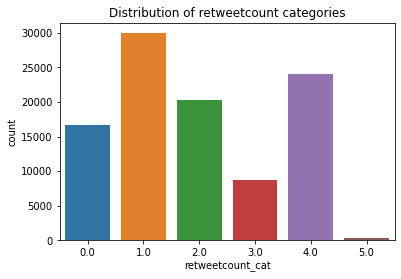

In [ ]:
# Plotting the frequency of each bin:
sns.countplot(data = df_pandas, x = 'retweetcount_cat').set(title='Distribution of retweetcount categories')

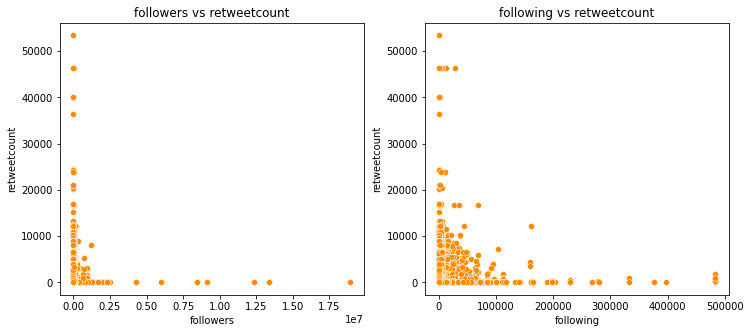

In [ ]:
import matplotlib.pyplot as plt
# Scatter plot of retweetcount vs followers and totaltweets:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))

ax1.set_title('followers vs retweetcount')
sns.scatterplot(x='followers', y='retweetcount', data=df_pandas, color = "darkorange", ax=ax1)

ax2.set_title('following vs retweetcount')
sns.scatterplot(x='following', y='retweetcount', data=df_pandas, color = "darkorange", ax=ax2)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


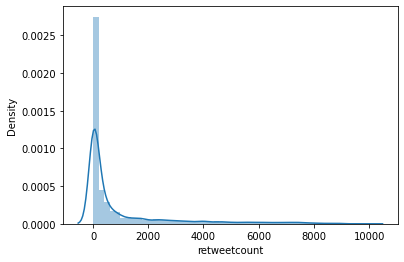

In [ ]:
# Plotting the distribution of the retweet count with filtering the outliers, i.e. tweets with retweet count > 10000:
sns.distplot(df_pandas[df_pandas["retweetcount"]<10000]['retweetcount'])

### Tokenize, Vectorize and IDF

In [ ]:
import pyspark.ml.feature
from pyspark.ml.feature import Tokenizer, CountVectorizer, IDF

In [ ]:
tokenizer = Tokenizer(inputCol= 'Cleaned_text', outputCol='tokens')
vectorizer = CountVectorizer(inputCol = 'tokens', outputCol = 'raw_features')
idf = IDF(inputCol= 'raw_features', outputCol = 'vectorized_features')

In [ ]:
tokenizer.transform(en_df_subset).limit(1).select('tokens').show()

+--------------------+
|              tokens|
+--------------------+
|[anonym, collect,...|
+--------------------+



In [ ]:
tokens = tokenizer.transform(en_df_subset)

In [ ]:
vectors = vectorizer.fit(tokens)

## Model Building

#### Train-Test Split

In [ ]:
# Splitting the dataset:
(trainDF, testDF) = en_df_subset.randomSplit((0.8, 0.2), seed = 480)


In [ ]:
# Estimator model: -- classification
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import LinearSVC, OneVsRest
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

#### **Classification**

With retweetcount_cat as the dependent variable, we perform classification. (retweetcount_cat is created by creating fixed bins using retweetcount column).

##### Logistics Regression

In [ ]:
# Building the pipeline:
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors

lr = LogisticRegression(featuresCol= 'vectorized_features', labelCol='retweetcount_cat')
pipeline = Pipeline(stages = [tokenizer, vectorizer, idf, lr])
lr_model = pipeline.fit(trainDF)

In [ ]:
# Predictions:
pred_train = lr_model.transform(trainDF)
pred_test = lr_model.transform(testDF)

#evaluation
evaluator_acc = MulticlassClassificationEvaluator(labelCol= 'retweetcount_cat', predictionCol = 'prediction', metricName = 'accuracy')
evaluator_f1 = MulticlassClassificationEvaluator(labelCol= 'retweetcount_cat', predictionCol = 'prediction', metricName = 'f1')

In [ ]:
accuracy_train = evaluator_acc.evaluate(pred_train)
accuracy_test = evaluator_acc.evaluate(pred_test)

f1_train = evaluator_f1.evaluate(pred_train)
f1_test = evaluator_f1.evaluate(pred_test)

In [ ]:
print("The accuracy through Logistic Regression over Training dataset is:", accuracy_train)
print("The accuracy through Logistic Regression over Testing dataset is:", accuracy_test)
print("The f1-score through Logistic Regression over Training dataset is:", f1_train)
print("The f1-score through Logistic Regression over Testing dataset is:", f1_test)

The accuracy through Logistic Regression over Training dataset is: 0.8956928512777128
The accuracy through Logistic Regression over Testing dataset is: 0.8701311705216782
The f1-score through Logistic Regression over Training dataset is: 0.8912659083361605
The f1-score through Logistic Regression over Testing dataset is: 0.8667594543878913


##### Decision Tree

In [ ]:
# Building the pipeline:

dt_cls = DecisionTreeClassifier(featuresCol= 'vectorized_features', labelCol='retweetcount_cat')
pipeline = Pipeline(stages = [tokenizer, vectorizer, idf, dt_cls])
dt_cls_model = pipeline.fit(trainDF)

In [ ]:
# Predictions:
dt_pred_train = dt_cls_model.transform(trainDF)
dt_pred_test = dt_cls_model.transform(testDF)

#evaluation
evaluator_acc = MulticlassClassificationEvaluator(labelCol= 'retweetcount_cat', predictionCol = 'prediction', metricName = 'accuracy')
evaluator_f1 = MulticlassClassificationEvaluator(labelCol= 'retweetcount_cat', predictionCol = 'prediction', metricName = 'f1')

In [ ]:
dt_accuracy_train = evaluator_acc.evaluate(dt_pred_train)
dt_accuracy_test = evaluator_acc.evaluate(dt_pred_test)

dt_f1_train = evaluator_f1.evaluate(dt_pred_train)
dt_f1_test = evaluator_f1.evaluate(dt_pred_test)

In [ ]:
print("The accuracy through DecisionTree Classifier over Training dataset is:", dt_accuracy_train)
print("The accuracy through DecisionTree Classifier over Testing dataset is:", dt_accuracy_test)
print("The f1-score through DecisionTree Classifier over Training dataset is:", dt_f1_train)
print("The f1-score through DecisionTree Classifier over Testing dataset is:", dt_f1_test)

The accuracy through DecisionTree Classifier over Training dataset is: 0.6445295976510985
The accuracy through DecisionTree Classifier over Testing dataset is: 0.6398317813157104
The f1-score through DecisionTree Classifier over Training dataset is: 0.560542281336554
The f1-score through DecisionTree Classifier over Testing dataset is: 0.55763050157114


##### Random Forest Classifier

In [ ]:
# Building the pipeline:

rf_cls = RandomForestClassifier(featuresCol= 'vectorized_features', labelCol='retweetcount_cat')
pipeline = Pipeline(stages = [tokenizer, vectorizer, idf, rf_cls])
rf_cls_model = pipeline.fit(trainDF)

In [ ]:
# Predictions:
rf_pred_train = rf_cls_model.transform(trainDF)
rf_pred_test = rf_cls_model.transform(testDF)

#evaluation
evaluator_acc = MulticlassClassificationEvaluator(labelCol= 'retweetcount_cat', predictionCol = 'prediction', metricName = 'accuracy')
evaluator_f1 = MulticlassClassificationEvaluator(labelCol= 'retweetcount_cat', predictionCol = 'prediction', metricName = 'f1')

In [ ]:
rf_accuracy_train = evaluator_acc.evaluate(rf_pred_train)
rf_accuracy_test = evaluator_acc.evaluate(rf_pred_test)

rf_f1_train = evaluator_f1.evaluate(rf_pred_train)
rf_f1_test = evaluator_f1.evaluate(rf_pred_test)

In [ ]:
print("The accuracy through Random Forest Classifier over Training dataset is:", rf_accuracy_train)
print("The accuracy through Random Forest Classifier over Testing dataset is:", rf_accuracy_test)
print("The f1-score through Random Forest Classifier over Training dataset is:", rf_f1_train)
print("The f1-score through Random Forest Classifier over Testing dataset is:", rf_f1_test)

The accuracy through Random Forest Classifier over Training dataset is: 0.569384657493344
The accuracy through Random Forest Classifier over Testing dataset is: 0.5635325923700811
The f1-score through Random Forest Classifier over Training dataset is: 0.45397807047680905
The f1-score through Random Forest Classifier over Testing dataset is: 0.4471206192881868


#### **Regression**

With retweetcount as the dependent variable, we perform regression.

In [ ]:
# Estimator model: -- classification
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

##### Decision Trees

In [ ]:
# Building the pipeline:

dt_reg = DecisionTreeRegressor(featuresCol= 'vectorized_features', labelCol='retweetcount')
pipeline = Pipeline(stages = [tokenizer, vectorizer, idf, dt_reg])
dt_reg_model = pipeline.fit(trainDF)

In [ ]:
# Predictions:
dt_reg_pred_train = dt_reg_model.transform(trainDF)
dt_reg_pred_test = dt_reg_model.transform(testDF)

#evaluation
evaluator_rmse = RegressionEvaluator(labelCol= 'retweetcount', predictionCol = 'prediction', metricName = 'rmse')
evaluator_mae = RegressionEvaluator(labelCol= 'retweetcount', predictionCol = 'prediction', metricName = 'mae')

In [ ]:
dt_rmse_train = evaluator_rmse.evaluate(dt_reg_pred_train)
dt_rmse_test = evaluator_rmse.evaluate(dt_reg_pred_test)

dt_mae_train = evaluator_mae.evaluate(dt_reg_pred_train)
dt_mae_test = evaluator_mae.evaluate(dt_reg_pred_test)

In [ ]:
print("The rmse through DecisionTree Regressor over Training dataset is:", dt_rmse_train)
print("The rmse through DecisionTree Regressor over Testing dataset is:", dt_rmse_test)
print("The mae through DecisionTree Regressor over Training dataset is:", dt_mae_train)
print("The mae through DecisionTree Regressor over Testing dataset is:", dt_mae_test)

The rmse through DecisionTree Regressor over Training dataset is: 1148.5664684367111
The rmse through DecisionTree Regressor over Testing dataset is: 1207.7171141513652
The mae through DecisionTree Regressor over Training dataset is: 560.1517437979294
The mae through DecisionTree Regressor over Testing dataset is: 581.0878375470124


##### Random Forest

In [ ]:
# Building the pipeline:

rf_reg = RandomForestRegressor(featuresCol= 'vectorized_features', labelCol='retweetcount')
pipeline = Pipeline(stages = [tokenizer, vectorizer, idf, rf_reg])
rf_reg_model = pipeline.fit(trainDF)

In [ ]:
# Predictions:
rf_reg_pred_train = rf_reg_model.transform(trainDF)
rf_reg_pred_test = rf_reg_model.transform(testDF)

#evaluation
evaluator_rmse = RegressionEvaluator(labelCol= 'retweetcount', predictionCol = 'prediction', metricName = 'rmse')
evaluator_mae = RegressionEvaluator(labelCol= 'retweetcount', predictionCol = 'prediction', metricName = 'mae')

In [ ]:
rf_rmse_train = evaluator_rmse.evaluate(rf_reg_pred_train)
rf_rmse_test = evaluator_rmse.evaluate(rf_reg_pred_test)

rf_mae_train = evaluator_mae.evaluate(rf_reg_pred_train)
rf_mae_test = evaluator_mae.evaluate(rf_reg_pred_test)

In [ ]:
print("The rmse through RandomForest Regressor over Training dataset is:", rf_rmse_train)
print("The rmse through RandomForest Regressor over Testing dataset is:", rf_rmse_test)
print("The mae through RandomForest Regressor over Training dataset is:", rf_mae_train)
print("The mae through RandomForest Regressor over Testing dataset is:", rf_mae_test)

The rmse through RandomForest Regressor over Training dataset is: 1240.5988452397087
The rmse through RandomForest Regressor over Testing dataset is: 1188.6665950250256
The mae through RandomForest Regressor over Training dataset is: 584.2543281799412
The mae through RandomForest Regressor over Testing dataset is: 596.8010815141654
